# Домашнее задание 5. Линейные модели

In [98]:
%matplotlib inline

In [99]:
import sys

import random as pr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cross_validation as cv
import sklearn.metrics as sm

Зачитываем результат 4 домашки

In [100]:
hw4_results = np.load("../hw4/files/out_4.dat.npz")
users = hw4_results["users"]
x_raw = hw4_results["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [101]:
TRAINING_SET_URL = "../hw1/twitter_train.csv"

df_users = pd.read_csv(TRAINING_SET_URL,
                       sep=",",
                       header=0,
                       names=["twitter_id", "is_1", "is_2", "is_3"],
                       dtype={"twitter_id": str, "is_1": int, 'is_2': int, "is_3": int})
df_users.set_index("twitter_id", inplace=True)

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [102]:
def f(x):
    if x[0] == 1:
        return 1
    if x[1] == 1:
        return 2
    if x[2] == 1:
        return 3

y_cleaned = df_users[['is_1', 'is_2', 'is_3']].apply(f, axis=1).values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (x_raw.shape[0], x_raw.shape[1], y_cleaned.shape[0])

Resulting training set: (3000x364911) feature matrix, 3000 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

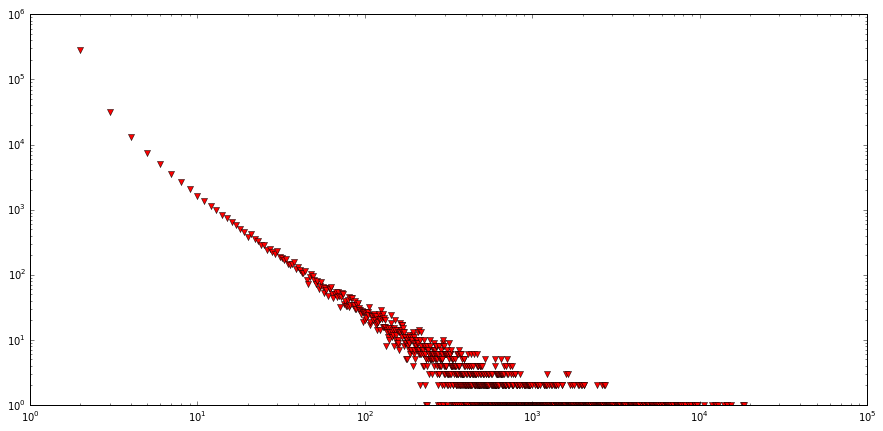

In [103]:
def draw_log_hist(data):
    """
    Draw tokens histogram in log scales
    """
    y = np.bincount(np.asarray(data.astype(int).sum(axis=0)).ravel())
    x = np.arange(1, len(y) + 1)
    
    plt.figure(figsize=(15,7))
    plt.xscale("log", nonposx='clip')
    plt.yscale("log", nonposy='clip')
    
#     plt.plot(x, np.sort(y)[::-1], "rv")
    plt.plot(x, y, "rv")
    return np.sort(y)[::-1]

features_counts = draw_log_hist(x_raw)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [104]:
x_cleaned = x_raw.tocsc()[:, features_counts > 100].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [105]:
USER_NAME = "b.kopin"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


Реализуем выбранный алгоритм

In [106]:
def _sigmoid(z):
        """
        Return Sigmoid of z
        Args:
            z : ndarray or scalar
        """
        return 1.0 / (1.0 + np.exp(-z))

def _logistic_grad(w, X, y, C):
    grad = (_sigmoid(X.dot(w)) - y).T.dot(X) / X.shape[0]
    grad[1:] += C

    return grad

In [119]:
class LogisticRegression():
    def __init__(self, tol=0.001, C=1.0, B=0.8, max_iter=100, fit_intercept=True, verbose=True):
        self.tol = tol
        self.C = C
        self.B = B
        self.max_iter = max_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
        n_samples, n_features = X.shape
        m_classes = len(np.unique(y))
        
        if m_classes > 2:
            labels = [y == label for label in np.unique(y)]
        else:
            labels = [y]
            
        self.coefs_ = np.zeros((m_classes, n_features))
        self.max_iters_ = np.zeros(m_classes)
        self.convergeds_ = np.zeros(m_classes, dtype=np.bool)
        
        for j, curr_y in enumerate(labels):
            if self.verbose:
                print "Fit coefs for %d" % (j + 1)

            for i in range(self.max_iter):                
                grad = _logistic_grad(self.coefs_[j], X, curr_y, self.C)

                eta = (i + 1) ** (-self.B)
                self.coefs_[j] -= eta * grad
                
                if self.verbose:
                    sys.stdout.write("\r Iter = %i grad = %f" % (i, np.sum(np.abs(eta * grad))))
                    sys.stdout.flush()

                if np.all(np.abs(eta * grad) < self.tol):
                    self.convergeds_[j] = True
                    self.max_iters_[j] = i + 1
                    
                    if self.verbose:
                        sys.stdout.write("\n")
                        sys.stdout.flush()
                    break
        return self

    def load_metadata(self, coefs, max_iters, convergeds):
        self.coefs_ = coefs
        self.max_iters_ = max_iters
        self.convergeds_ = convergeds

    def predict_proba(self, X):
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
        
        proba = np.asarray([_sigmoid(X.dot(coef)) for coef in self.coefs_])
        proba = proba / np.sum(proba, axis=0)
            
        return proba.T

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [108]:
x_train, x_test, y_train, y_test = cv.train_test_split(x_cleaned, y_cleaned, test_size=0.33)


In [109]:
from sklearn.preprocessing import label_binarize

def auroc(y_true, y_pred):
    """
    Compute auc-roc for multilabel data
    """
    return sm.roc_auc_score(label_binarize(y_true, classes=np.unique(y_cleaned)),
                            label_binarize(y_pred, classes=np.unique(y_cleaned)))

In [110]:
lg = LogisticRegression(max_iter=10000, B=0.8)
lg.fit(x_train, y_train);

Fit coefs for 1
 Iter = 5623 grad = 0.043611
Fit coefs for 2
 Iter = 5623 grad = 0.043843
Fit coefs for 3
 Iter = 5623 grad = 0.043612


In [86]:
y_prob = lg.predict(x_test);

In [87]:
auroc(y_test, y_prob)

0.5028646247228088

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [111]:
from sklearn.cross_validation import KFold

C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y):
    scores = []
    
    n_samples, n_features = X.shape
    kf = KFold(n_samples)
    
    for c in C:
#         print "="*10
#         print "C = %f" % c
        clf = LogisticRegression(C=c, max_iter=1000,  B=0.8, verbose=False)
        c_scores = []
        
        for k, indices in enumerate(kf):
#             print "Fold = %d" % (k + 1)
            train_f, test_f = indices
            clf.fit(X[train_f], Y[train_f])
            
            y_pred = clf.predict(X[test_f])
            auc = auroc(Y[test_f], y_pred)
            
            c_scores.append(auc)
#             print auc
        scores.append(c_scores)
    scores = np.asarray(scores)
    
#     print np.median(scores, axis=1)
    best_auc = np.argmax(np.median(scores, axis=1))
    
#     print best_auc
        
    return best_auc

index = select_reg_parameter(C, x_train, y_train)
print index


3


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

Area under the ROC curve : 0.469611


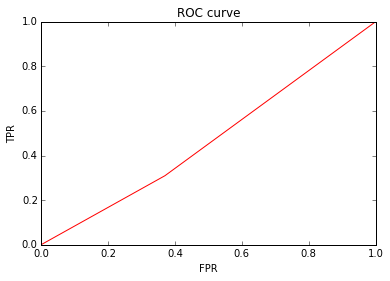

Area under the ROC curve : 0.500000


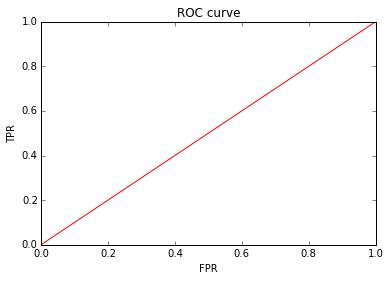

Area under the ROC curve : 0.500000


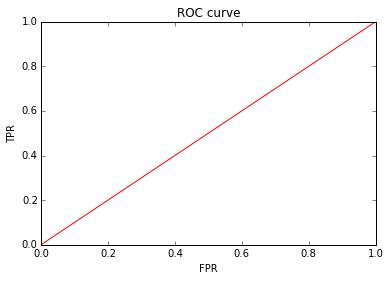

In [121]:
def predict(X, Y, test_size, C):
    x_train, x_test, y_train, y_test = cv.train_test_split(X, Y, test_size=test_size)
    
    clf = LogisticRegression(verbose=False)
    clf.fit(x_train, y_train)
    
    y_prob = clf.predict_proba(x_test)
    return y_test, y_prob

def roc(y_test, y_prob, y_prob_ind, pos_label):
    y_bin = np.zeros(y_test.size)
    
    y_bin[y_test == pos_label] = 1
    y_bin_p = 1 * (y_prob[:, y_prob_ind] > 0.5)
    
    fpr, tpr, _ = sm.roc_curve(y_bin, y_bin_p)
    roc_auc = sm.roc_auc_score(y_bin, y_bin_p)

    return tpr, fpr, roc_auc
    
def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    plt.title("ROC curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
    plt.plot(fpr, tpr, c='r')
    plt.show()

y_test, y_prob = predict(x_cleaned, y_cleaned, 0.3, C[index])

np.asarray(y_prob)

tpr, fpr, roc_auc = roc(y_test, y_prob, 0, 1)
print "Area under the ROC curve : %f" % roc_auc
plot_roc_curve(tpr, fpr, roc_auc)

tpr, fpr, roc_auc = roc(y_test, y_prob, 1, 2)
print "Area under the ROC curve : %f" % roc_auc
plot_roc_curve(tpr, fpr, roc_auc)

tpr, fpr, roc_auc = roc(y_test, y_prob, 2, 3)
print "Area under the ROC curve : %f" % roc_auc
plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате.